In [5]:
%load_ext autoreload
%autoreload 2

In [63]:
import os
# need to set gpus before anything involving pytorch
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

import torch
import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

os.chdir('/data7/brandon/research/DA_MVR/occ_net/occupancy_networks')
from im2mesh import config
from im2mesh.checkpoints import CheckpointIO
from im2mesh.utils.libmise import MISE

In [39]:
# da is a boolean indicating to use the target dataset or not
# returns latent vectors, and their image names
def get_latent_vecs(config_yaml, da):
    device = torch.device("cuda")
    cfg = config.load_config(config_yaml, 'configs/default.yaml')
    
    dataset = config.get_dataset('test', cfg, return_idx=True, use_target_domain = da)
    model = config.get_model(cfg, device=device, dataset=dataset)
    out_dir = cfg['training']['out_dir']
    checkpoint_io = CheckpointIO(out_dir, model=model)
    # load with 'cuda:0' because we set visible devices earlier
    checkpoint_io.load(cfg['test']['model_file'], 'cuda:0')
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
    generator = config.get_generator(model, cfg, device=device)
    model.eval()
    
    latent_vecs = []
    model_names = []
    for it, data in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            # get model name info
            idx = data['idx'].item()
            model_dict = dataset.get_model_dict(idx)
            modelname = model_dict['model']
            model_names.append(modelname)
            
            # get latent vector from data
            inputs = data.get('inputs', torch.empty(1, 0)).to(device)
            c = model.encode_inputs(inputs)
            #latent_vecs.append(c.cpu().detach().numpy())
            latent_vecs.append(c)
            
    return latent_vecs, model_names

In [31]:
def generate_latent_mesh(c, mesh_save_path, config_yaml):
    device = torch.device("cuda")
    cfg = config.load_config(config_yaml, 'configs/default.yaml')
    model = config.get_model(cfg, device=device)
    out_dir = cfg['training']['out_dir']
    checkpoint_io = CheckpointIO(out_dir, model=model)
    # load with 'cuda:0' because we set visible devices earlier
    checkpoint_io.load(cfg['test']['model_file'], 'cuda:0')
    generator = config.get_generator(model, cfg, device=device)
    model.eval()
    
    with torch.no_grad():
        z = model.get_z_from_prior((1,), sample=False).to(device)
        mesh = generator.generate_from_latent(z, c)
        mesh.export(mesh_save_path)

In [37]:
yaml = "out/DA_related/onet_chair_no_DA/chair_noDA.yaml"
base_out_dir =  os.path.join("notebooks", "latent_models")

In [40]:
latent_vecs, model_names = get_latent_vecs(yaml, False)

  0%|          | 0/1355 [00:00<?, ?it/s]

out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


100%|██████████| 1355/1355 [01:48<00:00, 12.54it/s]


In [26]:
# generate a bunch of examples from latent
for i in range(len(model_names)):
    model_path = os.path.join(base_out_dir, "{}_{}.off".format(i,model_names[i]))
    generate_latent_mesh(latent_vecs[i], model_path, yaml)

out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


# Interpolation

In [36]:
# interpolate between two latent codes
i1 = 0
i2 = 2
num_steps = 5 # number of steps in between the original codes
interpolate_dir = os.path.join(base_out_dir, "{}_{}".format(model_names[i1], model_names[i2]))
os.makedirs(interpolate_dir)
for i,lam in enumerate(np.linspace(0,1,num_steps+2)):
    model_path = os.path.join(interpolate_dir, "{}_{}_{}.off".format(i,model_names[i1], model_names[i2]))
    generate_latent_mesh(latent_vecs[i1]*lam + latent_vecs[i2]*(1-lam), model_path, yaml)

out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


# Latent mean and variance

In [80]:
# analyzing latent vecs 
latent_vecs_matrix = []
for latent_vec in latent_vecs:
    latent_vecs_matrix.append(latent_vec.cpu().detach().numpy())
latent_vecs_matrix = np.concatenate(latent_vecs_matrix,0)

latent_mean = np.mean(latent_vecs_matrix, axis = 0)
latent_cov = np.cov(latent_vecs_matrix, rowvar=False)
latent_var = np.diagonal(latent_cov)
latent_var_argsorted = np.argsort(latent_var)[::-1]
latent_var_sorted = latent_var[latent_var_argsorted]
for i in range(len(latent_var_argsorted)):
    print("feature idx: {}, variance: {}".format(latent_var_argsorted[i], latent_var_sorted[i]))

feature idx: 221, variance: 2.82319364072021
feature idx: 145, variance: 1.5541768688292505
feature idx: 218, variance: 1.46139833544985
feature idx: 185, variance: 1.2414991227688759
feature idx: 141, variance: 0.620156031649313
feature idx: 187, variance: 0.6088221295872903
feature idx: 48, variance: 0.4703418652781676
feature idx: 169, variance: 0.4690658837643483
feature idx: 80, variance: 0.44554964511368145
feature idx: 231, variance: 0.4340642027239793
feature idx: 61, variance: 0.3014981142032815
feature idx: 252, variance: 0.28873795116458306
feature idx: 45, variance: 0.23520061473848353
feature idx: 148, variance: 0.23027132353959215
feature idx: 89, variance: 0.21046432964145165
feature idx: 92, variance: 0.19195900813116074
feature idx: 125, variance: 0.1756902414224831
feature idx: 75, variance: 0.1664868571682186
feature idx: 115, variance: 0.14971062689226977
feature idx: 232, variance: 0.1488951881811841
feature idx: 130, variance: 0.14613640976920492
feature idx: 65, 

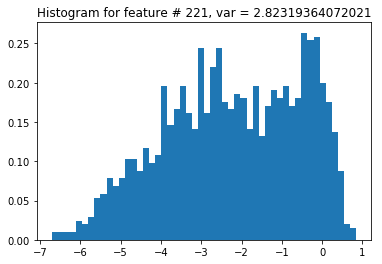

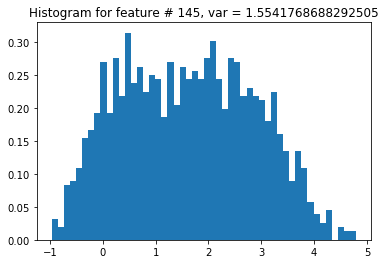

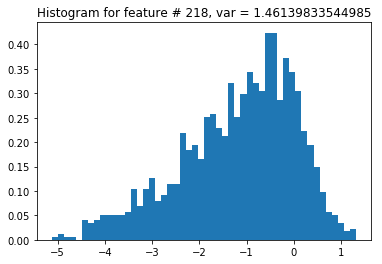

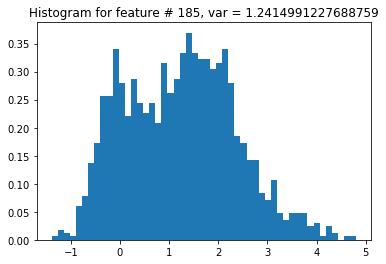

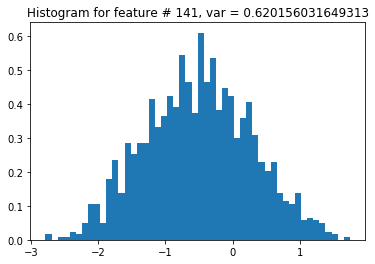

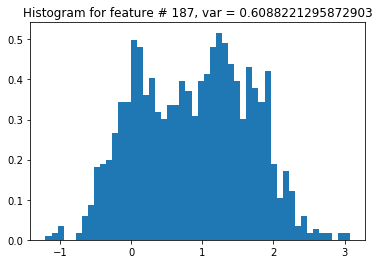

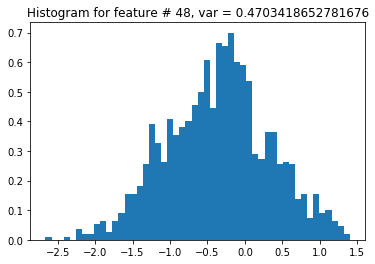

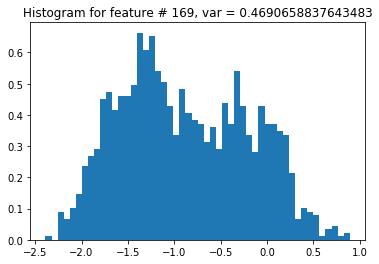

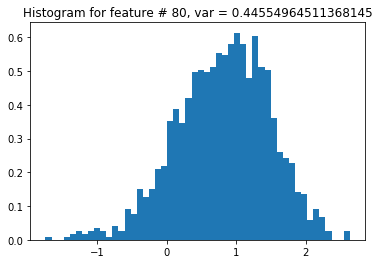

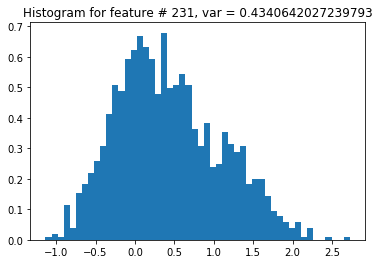

In [86]:
for i in range(10):
    plt.figure()
    feature_idx = latent_var_argsorted[i]
    feature_var = latent_var_sorted[i]
    n, bins, patches = plt.hist(latent_vecs_matrix[:,feature_idx], 50, density=True)
    plt.title("Histogram for feature # {}, var = {}".format(feature_idx, feature_var))

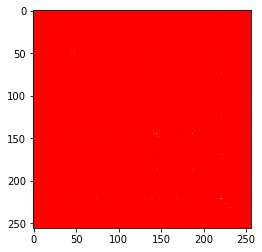

In [88]:
plt.imshow(latent_cov, interpolation="nearest", cmap="hot")

# Interpolation along a dimension

In [117]:
# modify a model with different values for a dimension
def interpolate_dimension(i, dim_i, stretch, num_steps):
    dim = latent_var_argsorted[dim_i]
    if stretch:
        interpolate_dir = os.path.join(base_out_dir, "{}_dim_{}_interpolate_stretch".format(model_names[i], dim))
    else:
        interpolate_dir = os.path.join(base_out_dir, "{}_dim_{}_interpolate".format(model_names[i], dim))
    if not os.path.exists(interpolate_dir):
        os.makedirs(interpolate_dir)

    c = latent_vecs[i]
    model_path = os.path.join(interpolate_dir, "original_{}_{}.off".format(c[0,dim],model_names[i]))
    generate_latent_mesh(c, model_path, yaml)

    # fix i
    dim_val_min = np.min(latent_vecs_matrix[:,dim])
    dim_val_max = np.max(latent_vecs_matrix[:,dim])
    if stretch:
        dim_range = abs(dim_val_max - dim_val_min)
        dim_val_min -= dim_range*5
        dim_val_max += dim_range*5
    for idx, new_dim_value in enumerate(np.linspace(dim_val_min, dim_val_max,num_steps)):
        model_path = os.path.join(interpolate_dir, "{}_{}_{}.off".format(idx, new_dim_value,model_names[i]))
        c_modified = torch.clone(c)
        c_modified[0,dim] = new_dim_value
        generate_latent_mesh(c_modified, model_path, yaml)

In [118]:
for model_i in [2,3,5]:
    for dim_i in [-1,-2,-3]:
        interpolate_dimension(model_i, dim_i, True, 4)

out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...
out/DA_related/onet_chair_no_DA/model_best.